In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - triaxial_potential_DF.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Evaluate the DF of the triaxial MW potential by integrating orbits and evaluating the 
DF in a known system.
'''

__author__ = "James Lane"

In [2]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
# from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import colors
from matplotlib import cm
# import aplpy

## Astropy
# from astropy.io import fits
# from astropy.coordinates import SkyCoord
# from astropy import table
from astropy import units as apu
# from astropy import wcs

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Add project-specific package. Assume relative location
sys.path.insert(0, os.path.abspath('../../src') )
import ast1501.potential

In [3]:
%matplotlib inline

## Keywords

In [4]:
## Halo evolution
t_evolve = 10 # Gyr
tform = -9 # Gyr ago
tsteady = 8 # Gyr after formation

## Make the potential

In [5]:
## Get MWPotential2014 and construct the potential
pot_parms = ast1501.potential.get_MWPotential2014()
mwbulge_alpha, mwbulge_rc, mwbulge_amp, mwdisk_a, mwdisk_b, mwdisk_amp, mwhalo_a, mwhalo_amp = pot_parms

# Make the potentials
mwbulge = potential.PowerSphericalPotentialwCutoff(amp=mwbulge_amp, alpha=mwbulge_alpha, rc=mwbulge_rc)
mwbulge.turn_physical_off()
mwdisk = potential.MiyamotoNagaiPotential(amp=mwdisk_amp, a=mwdisk_a, b=mwdisk_b)
mwdisk.turn_physical_off()
mwhalo = potential.NFWPotential(amp=mwhalo_amp, a=mwhalo_a)
mwhalo.turn_physical_off()

# Make the negative amplitude NFW and wrap it
mwhalo_rev = potential.NFWPotential(amp=-1*mwhalo_amp,
                                    a=mwhalo_a)
mwhalo_rev_dsw = potential.DehnenSmoothWrapperPotential(pot=mwhalo_rev, tform=tform*apu.Gyr, 
                                                        tsteady=tsteady*apu.Gyr)
mwhalo_rev_dsw.turn_physical_off()

# Make MWPotential2014
mwpot = [mwhalo, mwdisk, mwbulge]

## Make the distribution function

In [6]:
## Make the quasi-isothermal distribution function. See notebook #3 for the velocity scales.

# Velocity dispersions in km/s
sigma_vR = 46/1.5
sigma_vT = 40/1.5
sigma_vZ = 28/1.5

# Action angle coordinates and the DF
qdf_aA= actionAngleAdiabatic(pot=potential.MWPotential2014, c=True)
qdf = df.quasiisothermaldf( hr= 2*apu.kpc,
                            sr= sigma_vR*(apu.km/apu.s),
                            sz= sigma_vZ*(apu.km/apu.s),
                            hsr= 9.8*(apu.kpc),
                            hsz= 7.6*(apu.kpc),
                            pot= potential.MWPotential2014, 
                            aA= qdf_aA)

# Perform the integration over values of Phi

In [7]:
## Make the halo parameter arrays

# Make a 1-D grid of halo values to test.
phi_range = np.linspace(0, np.pi/2, 5)

# The times over which each orbit will be integrated
times = -np.array([0,t_evolve]) * apu.Gyr

In [8]:
# Now make the grid for our velocities, which will span 2sigma (approx) in each of R,T,Z velocities
# Manually set ranges for clean dV
dvT = 10.
dvR = 10.
vR_low = -120
vR_hi = 120
vT_low = -100
vT_hi = 100
vR_range = np.arange( vR_low, vR_hi, dvR )
vT_range = np.arange( vT_low, vT_hi, dvT )+210 # Plus rotational velocity minus 10 for Assym. Drift.

# This goes along with a grid of distribution function values. The perturbed array will have one 
# dimension for the changing halo parameters. The unperturbed DF will not change, so only 2D
dfp = np.zeros((len(phi_range),len(vR_range),len(vT_range)))
df0 = np.zeros((len(vR_range),len(vT_range)))

print( str(len(vR_range)*len(vT_range))+' independent velocities' )

480 independent velocities


In [9]:
## Now loop over all of the orbit possibilities, evaluate them in a triaxial NFW which evolves backwards to 
## become a smooth NFW

# Timing
ot_total = 0
oit_total = 0
dft_total = 0

tott_start = time.time()

for i in range( len(phi_range) ):

    # Make the halo for this parameter and wrap it
    trihalo = potential.TriaxialNFWPotential(amp = mwhalo_amp, a = mwhalo_a, b = 2.0, pa = phi_range[i])
    trihalo_dsw = potential.DehnenSmoothWrapperPotential(pot=trihalo, tform=tform*apu.Gyr, tsteady=tsteady*apu.Gyr)
    trihalo_dsw.turn_physical_off()
    
    # Make the triaxial potential
    tripot_grow = [mwhalo, mwhalo_rev_dsw, trihalo_dsw, mwdisk, mwbulge]
    
    # Loop over the velocities
    for j in range( len(vR_range) ):
        for k in range( len(vT_range) ):
        
            # Make the orbit
            o = orbit.Orbit(vxvv=[8.*apu.kpc, 
                                  vR_range[j]*apu.km/apu.s, 
                                  vT_range[k]*apu.km/apu.s, 
                                  0.*apu.kpc,
                                  0.*apu.km/apu.s,
                                  0.*apu.radian])
            
            # Evaluate the unperturbed distribution function if this is the first run-through
            if i == 0:            
                df0[j,k] = qdf(o)
            ##fi
            
            oit_start = time.time()
            o.integrate(times, tripot_grow)
            oit_end = time.time()
        
            # Now evaluate the perturbed distribution function
            dft_start = time.time()
            dfp[i,j,k] = qdf(o(times[1]))
            dft_end = time.time()
        
            oit_total += (oit_end-oit_start)
            dft_total += (dft_end-dft_start)
        
tott_end = time.time()

# Display timing statistics
print('Took '+str(round(tott_end-tott_start,2))+' s total')
print('Orbit integration took '+str(round(oit_total,2))+' s')
print('DF evaluation took '+str(round(dft_total,2))+' s')
print('Took '+str(round((tott_end-tott_start)/(len(vR_range)*len(vT_range)),2))+' s per velocity')

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/galpy/df/quasiisothermaldf.py:281: RuntimeWarning: overflow encountered in exp
  *numpy.exp(-kappa*jr*srm2)

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/galpy/df/quasiisothermaldf.py:281: RuntimeWarning: invalid value encountered in multiply
  *numpy.exp(-kappa*jr*srm2)

Took 717.24 s total
Orbit integration took 709.47 s
DF evaluation took 4.75 s
Took 1.49 s per velocity


## Plotting
### First show the distribution function

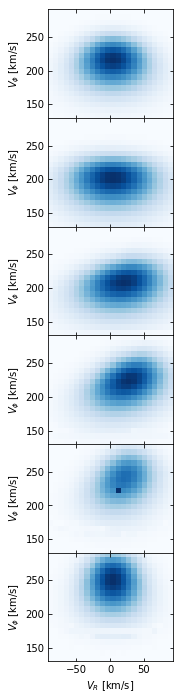

In [68]:
fig = plt.figure( figsize=(6,12) )
axs = fig.subplots( nrows=len(phi_range)+1, ncols=1)

# Loop over all halo parameters
for i in range( len(phi_range)+1 ):
    
    if i == 0:
        img_arr = np.rot90( df0/np.max(df0) )
        img = axs[0].imshow(img_arr, interpolation='nearest',
                            extent=[-2*sigma_vR, 2*sigma_vR+1, 210-2*sigma_vT, 210+2*sigma_vT+1],
                            cmap='Blues', vmax=1, vmin=0)

        # Decorate
        #cbar = plt.colorbar(img)

        # Adjust
        axs[0].set_ylabel(r'$V_{\phi}$ [km/s]')
        axs[0].tick_params(direction='in', top='on', right='on', labelbottom='off')
        #cbar.set_label('Log[f/fmax]')
    
    else:
        img_arr = np.rot90( dfp[i-1]/np.max(dfp[i-1]) )
        img = axs[i].imshow(img_arr, interpolation='nearest',
                            extent=[-2*sigma_vR, 2*sigma_vR+1, 210-2*sigma_vT, 210+2*sigma_vT+1],
                            cmap='Blues', vmax=1, vmin=0)

        # Decorate
        #cbar = plt.colorbar(img)

        # Adjust
        axs[i].set_ylabel(r'$V_{\phi}$ [km/s]')
        #cbar.set_label('Log[f/fmax]')

        if i != (len(phi_range)):
            axs[i].tick_params(direction='in', top='on', right='on', labelbottom='off')
        else:
            axs[i].tick_params(direction='in', top='on', right='on')
            axs[i].set_xlabel(r'$V_{R}$ [km/s]')
###i

fig.subplots_adjust(hspace=0)
plt.show()

## Now show the change in the moments with the change in phi

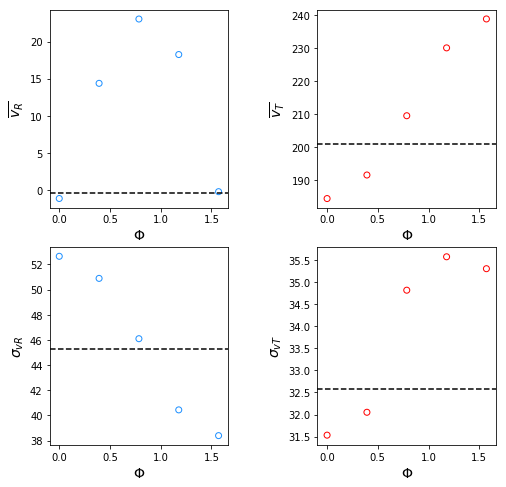

In [66]:
dvT = 10.
vT_low = -100
vT_hi = 100
vT_range = np.arange( vT_low, vT_hi, dvT )+210

fig = plt.figure( figsize=(8,8) )
axs = fig.subplots( nrows=2, ncols=2)

# First calculate density and moments for the unperturbed case
dens0 = np.sum(df0) * dvR * dvT # Units of 1/kpc**2
vR_avg0 = (1/dens0) * np.sum( np.sum(df0, axis=1) * vR_range ) * dvR * dvT
vT_avg0 = (1/dens0) * np.sum( np.sum(df0, axis=0) * vT_range ) * dvR * dvT
vR_std0 = np.sqrt((1/dens0) * np.sum( np.sum(df0, axis=1) * np.square( vR_avg0 - vR_range ) ) * dvR * dvT)
vT_std0 = np.sqrt((1/dens0) * np.sum( np.sum(df0, axis=0) * np.square( vT_avg0 - vT_range ) ) * dvR * dvT)

vR_avgp = np.zeros( len(phi_range) )
vT_avgp = np.zeros( len(phi_range) )
vR_stdp = np.zeros( len(phi_range) )
vT_stdp = np.zeros( len(phi_range) )

# Loop over all halo parameters
for i in range( len(phi_range) ):
    
    # First calculate the density
    densp = np.sum(dfp[i]) * dvR * dvT # Units of 1/kpc**2
    
    # Now calculate the moments
    vR_avgp[i] = (1/densp) * np.sum( np.sum(dfp[i], axis=1) * vR_range ) * dvR * dvT
    vT_avgp[i] = (1/densp) * np.sum( np.sum(dfp[i], axis=0) * vT_range ) * dvR * dvT
    vR_stdp[i] = np.sqrt((1/densp) * np.sum( np.sum(dfp[i], axis=1) * np.square( vR_avgp[i] - vR_range ) ) * dvR * dvT)
    vT_stdp[i] = np.sqrt((1/densp) * np.sum( np.sum(dfp[i], axis=0) * np.square( vT_avgp[i] - vT_range ) ) * dvR * dvT)

###i

axs[0,0].scatter( phi_range, vR_avgp, color='DodgerBlue', facecolor='None' )
axs[0,0].axhline( vR_avg0, linestyle='dashed', color='Black' )
axs[0,0].set_xlabel(r'$\Phi$', fontsize=14)
axs[0,0].set_ylabel(r'$\overline{v_{R}}$', fontsize=14)

axs[1,0].scatter( phi_range, vR_stdp, color='DodgerBlue', facecolor='None' )
axs[1,0].axhline( vR_std0, linestyle='dashed', color='Black' )
axs[1,0].set_xlabel(r'$\Phi$', fontsize=14)
axs[1,0].set_ylabel(r'$\sigma_{vR}$', fontsize=14)

axs[0,1].scatter( phi_range, vT_avgp, color='Red', facecolor='None' )
axs[0,1].axhline( vT_avg0, linestyle='dashed', color='Black' )
axs[0,1].set_xlabel(r'$\Phi$', fontsize=14)
axs[0,1].set_ylabel(r'$\overline{v_{T}}$', fontsize=14)

axs[1,1].scatter( phi_range, vT_stdp, color='Red', facecolor='None' )
axs[1,1].axhline( vT_std0, linestyle='dashed', color='Black' )
axs[1,1].set_xlabel(r'$\Phi$', fontsize=14)
axs[1,1].set_ylabel(r'$\sigma_{vT}$', fontsize=14)

fig.subplots_adjust(wspace=0.5)
plt.tight_layout
plt.show()